In [2]:
import mxnet as mx


(rf : https://aws.amazon.com/ko/blogs/korea/aws-deep-learning-framework-mxnet/)

# Imperative

In [4]:
a = mx.nd.array([1,2,3])
b = a * 2 +1
print(b)
print(b.asnumpy())

<NDArray 3 @cpu(0)>
[ 3.  5.  7.]


# Declarative

In [5]:
a = mx.sym.Variable('a')
b = a * 2 + 1
ex = b.bind(ctx=mx.cpu(0), args={'a' : mx.nd.array([1,2,3])})
print(ex.forward())
print(ex.outputs[0].asnumpy())

[<NDArray 3 @cpu(0)>]
[ 3.  5.  7.]


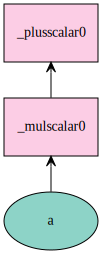

In [7]:
# pip install graphviz

vis = mx.viz.plot_network(symbol=b)
vis

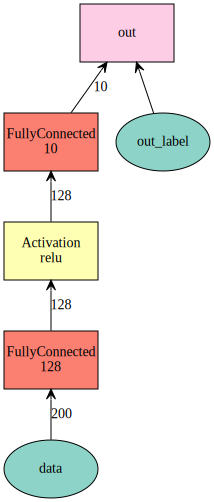

In [11]:
# Basic Neural Networks
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=net, name='relu1', act_type="relu")
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=10)
net = mx.sym.SoftmaxOutput(data=net, name='out')
vis = mx.viz.plot_network(net, shape={'data': (100,200)})
vis

# Linear Regression

### Prepare

In [3]:
import mxnet as mx
import numpy as np

# Training data
train_data = np.random.uniform(0,1, [100,2])
train_label = np.array([train_data[i][0] + 2 * train_data[i][1] for i in range(100)])
batch_size = 1

# Evaluation Data
eval_data = np.array([[7,2], [6,10], [12,2]])
eval_label = np.array([11,26,16])

train_iter = mx.io.NDArrayIter(train_data, train_label, batch_size, shuffle=True, label_name='lin_reg_label')
eval_iter = mx.io.NDArrayIter(eval_data, eval_label, batch_size, shuffle=False)

### Define Model

In [4]:
X = mx.sym.Variable('data')
Y = mx.symbol.Variable('lin_reg_label')
fully_connected_layer = mx.sym.FullyConnected(data=X, name='fcl', num_hidden=1)
lro = mx.sym.LinearRegressionOutput(data=fully_connected_layer, label=Y, name='lro')

model = mx.mod.Module(
    symbol = lro,
    data_names = ['data'],
    label_names = ['lin_reg_label']  # network structure
)

In [19]:
print(train_iter.data)
print(train_iter.label)

[('data', <NDArray 100x2 @cpu(0)>)]
[('lin_reg_label', <NDArray 100 @cpu(0)>)]


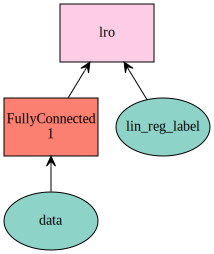

In [5]:
mx.viz.plot_network(symbol = lro)

### Train

- High Level Interface

In [6]:
## simple way to make model
## this model is including below: Intermediate Level Interface
model.fit(train_iter,
          optimizer_params={'learning_rate':0.0005, 'momentum':0.9},
          num_epoch = 10)        

- Intermediate Level Interface

In [26]:
model.bind(data_shapes = train_iter.provide_data,
           label_shapes = train_iter.provide_label, for_training = True)

model.init_params()
model.init_optimizer(optimizer='sgd', optimizer_params=(('learning_rate',0.005),('momentum', 0.9),))

for k in range(10):
    train_iter.reset()
    for n, data_batch in enumerate(train_iter):
        model.forward(data_batch)
        model.backward()
        model.update()

/home/multi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  after removing the cwd from sys.path.


### Visualize

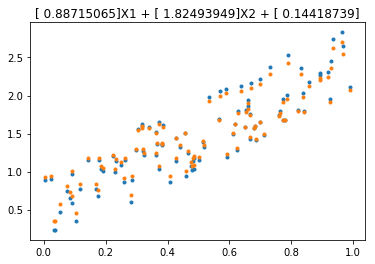

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import mxnet as mx
import numpy as np

# Training data
train_data = np.random.uniform(0,1, [100,2])
train_label = np.array([train_data[i][0] + 2 * train_data[i][1] for i in range(100)])
batch_size = 1

# Evaluation Data
eval_data = np.array([[7,2], [6,10], [12,2]])
eval_label = np.array([11,26,16])

train_iter = mx.io.NDArrayIter(train_data, train_label, batch_size, shuffle=True, label_name='lin_reg_label')
eval_iter = mx.io.NDArrayIter(eval_data, eval_label, batch_size, shuffle=False)

X = mx.sym.Variable('data')
Y = mx.symbol.Variable('lin_reg_label')
fully_connected_layer = mx.sym.FullyConnected(data=X, name='fcl', num_hidden=1)
lro = mx.sym.LinearRegressionOutput(data=fully_connected_layer, label=Y, name='lro')

model = mx.mod.Module(
    symbol = lro,
    data_names = ['data'],
    label_names = ['lin_reg_label']  # network structure
)

model.bind(data_shapes = train_iter.provide_data,
           label_shapes = train_iter.provide_label, 
           for_training = True)

model.init_params()
model.init_optimizer(optimizer='sgd', optimizer_params=(('learning_rate',0.005),('momentum', 0.9),))

for k in range(10):
    train_iter.reset()
    
    arg,aux = model.get_params()
    w = arg['fcl_weight'].asnumpy()
    bias = arg['fcl_bias'].asnumpy()
    abline_values = [w[:,0] * i[0] + w[:,1]*i[1] + bias for i in train_data[:]]
    
    plt.plot(train_data[:,1], train_label, '.')
    plt.plot(train_data[:,1], abline_values, '.')
    plt.title(str(w[:,0]) + str('X1 + ') + 
              str(w[:,1]) + str('X2') + str(' + ') + str(bias))
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    #plt.show()
    time.sleep(1.0)
    plt.gcf().clear()
    
    for n, data_batch in enumerate(train_iter):
        model.forward(data_batch)
        model.backward()
        model.update()
        
## Blue : Label
## Yellow : Predicted Value

### Predict

In [6]:
model.predict(eval_iter).asnumpy()

array([[ 10.19505215],
       [ 24.16858673],
       [ 14.73691845]], dtype=float32)

In [7]:
metric = mx.metric.MSE()
model.score(eval_iter, metric)

[('mse', 1.8657968640327454)]

In [8]:
eval_data = np.array([[7,2], [6,10], [12,2]])
eval_label = np.array([11.1,26.1,16.1]) # Adding 0,1 to each of the values
eval_iter = mx.io.NDArrayIter(eval_data, eval_label, batch_size, shuffle=False)
model.score(eval_iter, metric)

[('mse', 2.1357607642809548)]